In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

%matplotlib inline

Let's check if PyTorch is using GPU

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')
print(torch.cuda.get_device_name(0))

device: cuda:0
NVIDIA GeForce RTX 3060


## Data Exploration

The CSV file contained the house prices, the type of house asset (such as Condominium, Bungalow, etc.)

In [3]:
df = pd.read_csv("data_kaggle.csv")
print(len(df))

53883


In [4]:
df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,"KLCC, Kuala Lumpur","RM 1,250,000",2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,"Damansara Heights, Kuala Lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,"Dutamas, Kuala Lumpur","RM 1,030,000",3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
3,"Cheras, Kuala Lumpur",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Bukit Jalil, Kuala Lumpur","RM 900,000",4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished


## Data Cleaning (a.k.a Pre-processing)
We noticed that there are some rows are "NaN", which containing meaningless values.
Before make our hands wet, these values must be replace by mean either its mode or mean
corresponding to its location.

In [5]:
import re
import locale
locale.setlocale(locale.LC_ALL, 'en_US.utf8')

non_decimal = re.compile(r'[^\dx]+')

df['Price'] = df['Price'].apply(lambda x: non_decimal.sub('', str(x)))
df['Price'] = df['Price'].apply(lambda x: int(x) / 1000000 if x != '' else np.nan)

In [6]:
pattern = re.compile(r"[A-Za-z] : (.,?[\d.]+)[xX~]?(\d+)? sq. ft.")

def check_none(val):
    if not (val is None):
        return locale.atof(str(val))
    else:
        return 1

def format_size_col(x: str):
    m = re.search(pattern, str(x))
    if m:
        result = locale.atof(m.groups()[0]) * check_none(m.groups()[1])
        return result / 1000
    else:
        return float('nan')

df['Size'] = df['Size'].apply(lambda x: format_size_col(x))
# df['Size'] = df['Size'].apply(lambda x: np.sqrt(int(x)) if type(x) != str else float('nan'))

In [7]:
def format_room_col(x):
    return eval(str(x) if type(x) == str and x != 'Studio' else 'float("nan")')

df['Rooms'] = df['Rooms'].apply(lambda x: format_room_col(x))

In [8]:
furnishing_dict = {
    'Unfurnished': 0,
    'Partly Furnished': 1,
    'Fully Furnished': 2,
}

df['Furnishing'] = df['Furnishing'].apply(lambda x: int(furnishing_dict[x] if str(x) in furnishing_dict.keys() else 0))

In [9]:
df['Location'] = df['Location'].apply(lambda x: x.removesuffix(', Kuala Lumpur'))

### Handling missing values

When dealing with missing data, data scientists use two common methods to solve this 
problem: imputations, or just removing the row that contains missing value.

In this project, we will just drop the missing rows. 

In [10]:
df = df.dropna().reset_index(drop=True)

In [11]:
df[['Rooms', 'Bathrooms', 'Car Parks']] = df[['Rooms', 'Bathrooms', 'Car Parks']].astype('float').astype('int')

In [12]:
from sklearn.preprocessing import LabelEncoder

df['Location'] = LabelEncoder().fit_transform(df['Location'])
df

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,40,1.250,3,3,2,Serviced Residence,1.335,2
1,26,1.030,3,4,2,Condominium (Corner),1.875,1
2,11,0.900,5,3,2,Condominium (Corner),1.513,1
3,76,5.350,6,5,4,Bungalow,7.200,1
4,76,2.600,5,4,4,Semi-detached House,3.600,1
...,...,...,...,...,...,...,...,...
34424,46,0.585,4,3,2,Condominium,1.313,0
34425,39,1.400,4,3,2,Condominium (Corner),1.544,2
34426,38,0.880,1,1,1,Condominium (Corner),0.650,1
34427,66,2.700,6,6,3,Condominium (Corner),3.973,1


In [13]:
df['Property Type'] = LabelEncoder().fit_transform(df['Property Type'])
df

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,40,1.250,3,3,2,77,1.335,2
1,26,1.030,3,4,2,55,1.875,1
2,11,0.900,5,3,2,55,1.513,1
3,76,5.350,6,5,4,44,7.200,1
4,76,2.600,5,4,4,71,3.600,1
...,...,...,...,...,...,...,...,...
34424,46,0.585,4,3,2,54,1.313,0
34425,39,1.400,4,3,2,55,1.544,2
34426,38,0.880,1,1,1,55,0.650,1
34427,66,2.700,6,6,3,55,3.973,1


## Building Machine Learning Model

In [14]:
cat_feat = ["Location", "Rooms", "Bathrooms", "Car Parks", "Property Type", "Furnishing"]
out_feat = "Price"

In [15]:
cat = torch.tensor(df[cat_feat].to_numpy(), dtype=torch.int64).to(device)
cat

tensor([[40,  3,  3,  2, 77,  2],
        [26,  3,  4,  2, 55,  1],
        [11,  5,  3,  2, 55,  1],
        ...,
        [38,  1,  1,  1, 55,  1],
        [66,  6,  6,  3, 55,  1],
        [63,  4,  2,  3, 58,  1]], device='cuda:0')

In [16]:
# continuous features
cont_feat = "Size"
cont = torch.tensor(df[cont_feat].to_numpy(), dtype=torch.float32).reshape(-1, 1).to(device)
cont

tensor([[1.3350],
        [1.8750],
        [1.5130],
        ...,
        [0.6500],
        [3.9730],
        [1.3130]], device='cuda:0')

In [17]:
y = torch.tensor(df["Price"].to_numpy(), dtype=torch.float32).reshape(-1, 1).to(device)
y

tensor([[1.2500],
        [1.0300],
        [0.9000],
        ...,
        [0.8800],
        [2.7000],
        [0.5400]], device='cuda:0')

In [18]:
cat_dims = [len(df[col].unique()) for col in cat_feat]
cat_dims

[82, 17, 17, 21, 91, 3]

In [19]:
embedding_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]
embedding_dims

[(82, 41), (17, 9), (17, 9), (21, 11), (91, 46), (3, 2)]

In [20]:
class SparseTabularNN(nn.Module):
    def __init__(self, embedding_dim, n_cont, out_sz, layers, dropout_rate=0.5) -> None:
        super().__init__()
        self.embeds = nn.ModuleList([
            nn.Embedding(inp, out) for inp, out in embedding_dim
        ])
        self.emb_drop = nn.Dropout(dropout_rate)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layer_list = []
        n_emb = sum((out for _, out in embedding_dim))
        n_in = n_emb + n_cont

        for i in layers:
            layer_list.append(nn.Linear(n_in, i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(dropout_rate))
            n_in = i
        
        layer_list.append(nn.Linear(layers[-1], out_sz))
        
        self.layers = nn.Sequential(*layer_list)
        
    def forward(self, x_cat, x_cont):
        # embeddings = [e(x_cat[:,i]) for i, e in enumerate(self.embeds)]
        embeddings = [e(torch.clamp(x_cat[:,i], 0, e.num_embeddings - 1)) for i, e in enumerate(self.embeds)]
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x2 = self.bn_cont(x_cont)
        x = torch.cat([x, x2], 1)
        x = self.layers(x)

        return x

In [21]:
model = SparseTabularNN(embedding_dims, 1, 1, [200, 70], dropout_rate=0.40).to(device)

In [22]:
model.eval()

SparseTabularNN(
  (embeds): ModuleList(
    (0): Embedding(82, 41)
    (1-2): 2 x Embedding(17, 9)
    (3): Embedding(21, 11)
    (4): Embedding(91, 46)
    (5): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=119, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=70, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=70, out_features=1, bias=True)
  )
)

In [23]:
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

/home/pehcy/miniconda3/envs/nphouse/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
batch_size=1200
test_size=int(batch_size*0.15)
train_categorical=cat[:batch_size-test_size]
test_categorical=cat[batch_size-test_size:batch_size]
train_cont=cont[:batch_size-test_size]
test_cont=cont[batch_size-test_size:batch_size]
y_train=y[:batch_size-test_size]
y_test=y[batch_size-test_size:batch_size]

In [25]:
epochs=5000
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred=model(train_categorical,train_cont)
    loss=torch.sqrt(loss_fn(y_pred,y_train)) ### RMSE
    final_losses.append(loss.detach().cpu().numpy())
    
    if i % 100 == 1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch number: 1 and the loss : 3.3084442615509033
Epoch number: 101 and the loss : 0.3455871641635895
Epoch number: 201 and the loss : 0.2604268491268158
Epoch number: 301 and the loss : 0.24617673456668854
Epoch number: 401 and the loss : 0.2920239567756653
Epoch number: 501 and the loss : 0.16692057251930237
Epoch number: 601 and the loss : 0.171035036444664
Epoch number: 701 and the loss : 0.17176954448223114
Epoch number: 801 and the loss : 0.15402784943580627
Epoch number: 901 and the loss : 0.1608416587114334
Epoch number: 1001 and the loss : 0.15692640841007233
Epoch number: 1101 and the loss : 0.15699028968811035
Epoch number: 1201 and the loss : 0.15798527002334595
Epoch number: 1301 and the loss : 0.1548808068037033
Epoch number: 1401 and the loss : 0.15113461017608643
Epoch number: 1501 and the loss : 0.1514493077993393
Epoch number: 1601 and the loss : 0.14935405552387238
Epoch number: 1701 and the loss : 0.15204131603240967
Epoch number: 1801 and the loss : 0.1462035477161

Text(0.5, 0, 'epoch')

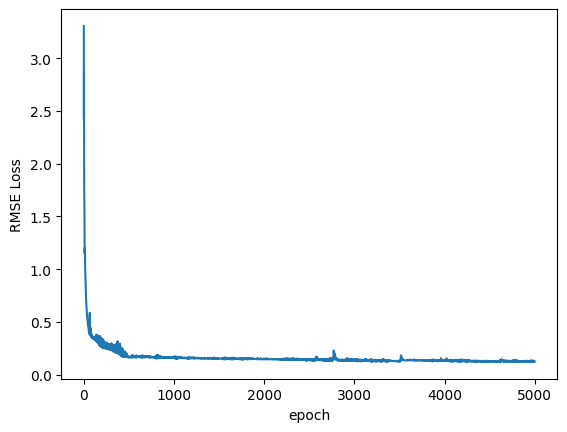

In [26]:
plt.plot(range(epochs), final_losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')

In [27]:
torch.save(model,'HousePrice.pt')